In [7]:
import numpy as np
import pandas as pd

import os

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [59]:
### merge overlap gene sets
dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
all_sets = os.listdir('../results/genesets/overlap/csvs/')
for rtype in ['filtered', 'random_uniform_0', 'random_dist_0']:
    for dname1 in dnames:
        for dname2 in dnames:
            if dname1 != dname2:
                name = dname1 + '_' + rtype + '_minus_' + dname2 + '_' + rtype
                results = pd.read_csv('../results/genesets/overlap/csvs/%s_0.csv' % name,
                                     sep=',', header=0, index_col=0)
                i = 1
                while True:
                    if (name + '_' + str(i)+'.csv') in all_sets:
                        data = pd.read_csv('../results/genesets/overlap/csvs/%s_%i.csv' % (name, i),
                                           sep=',', header=0, index_col=0)
                        results = pd.concat([results, data])
                        results.index = range(len(results))
                        i += 1
                    else:
                        break
                results.to_csv('../results/genesets/overlap/merged/%s.csv' % name)

In [61]:
def plot_set_difference(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    scores={}
    sizes = {}
    for dname1 in dnames:
        scores[dname1]=[]
        sizes[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_filtered',dname2,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size_1minus2 = pd.read_csv('../results/genesets/overlap/merged/%s%s_minus_%s%s.csv' % (dname1,'_filtered',dname2,'_filtered'),
                                      sep=',', header=0, index_col=0)['Set'].value_counts()
            size_1minus2 = size_1minus2[score_1minus2.index]
            scores[dname1]+=list(score_1minus2.values)
            sizes[dname1]+=list(size_1minus2.values)
    scores_df=pd.DataFrame(columns=['Data','Delta','Size'])
    for dname in scores:
        temp=pd.DataFrame(columns=scores_df.columns)
        temp['Delta']=scores[dname]
        temp['Data']=dname
        temp['Size']=sizes[dname]
        scores_df=pd.concat([scores_df,temp])
    scores_df['Random']='Actual gene set'
    scores_random={}
    sizes_random = {}
    for dname1 in dnames:
        scores_random[dname1]=[]
        sizes_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_random_dist_0',dname2,'_random_dist_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size_1minus2 = pd.read_csv('../results/genesets/overlap/merged/%s%s_minus_%s%s.csv' % (dname1,'_random_dist_0',dname2,'_random_dist_0'),
                                      sep=',', header=0, index_col=0)['Set'].value_counts()
            size_1minus2 = size_1minus2[score_1minus2.index]
            scores_random[dname1]+=list(score_1minus2.values)
            sizes_random[dname1] += list(size_1minus2.values)
    scores_random_df=pd.DataFrame(columns=['Data','Delta','Size'])
    for dname in scores_random:
        temp=pd.DataFrame(columns=scores_random_df.columns)
        temp['Delta']=scores_random[dname]
        temp['Data']=dname
        temp['Size']=sizes_random[dname]
        scores_random_df=pd.concat([scores_random_df,temp])
    scores_random_df['Random']='Random gene set'

    scores=pd.concat([scores_df, scores_random_df])
    scores.columns=['Data', 'Delta', 'Size','Gene set']
    scores = scores.sort_values(['Data','Gene set'])
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.boxplot(scores['Data'],scores['Delta'], hue=scores['Gene set'])
    plt.xlabel('Original gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                        'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score of\nset difference gene sets', size=15)
    plt.tight_layout()
    plt.legend(loc=2, title='Gene set')
    return scores

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


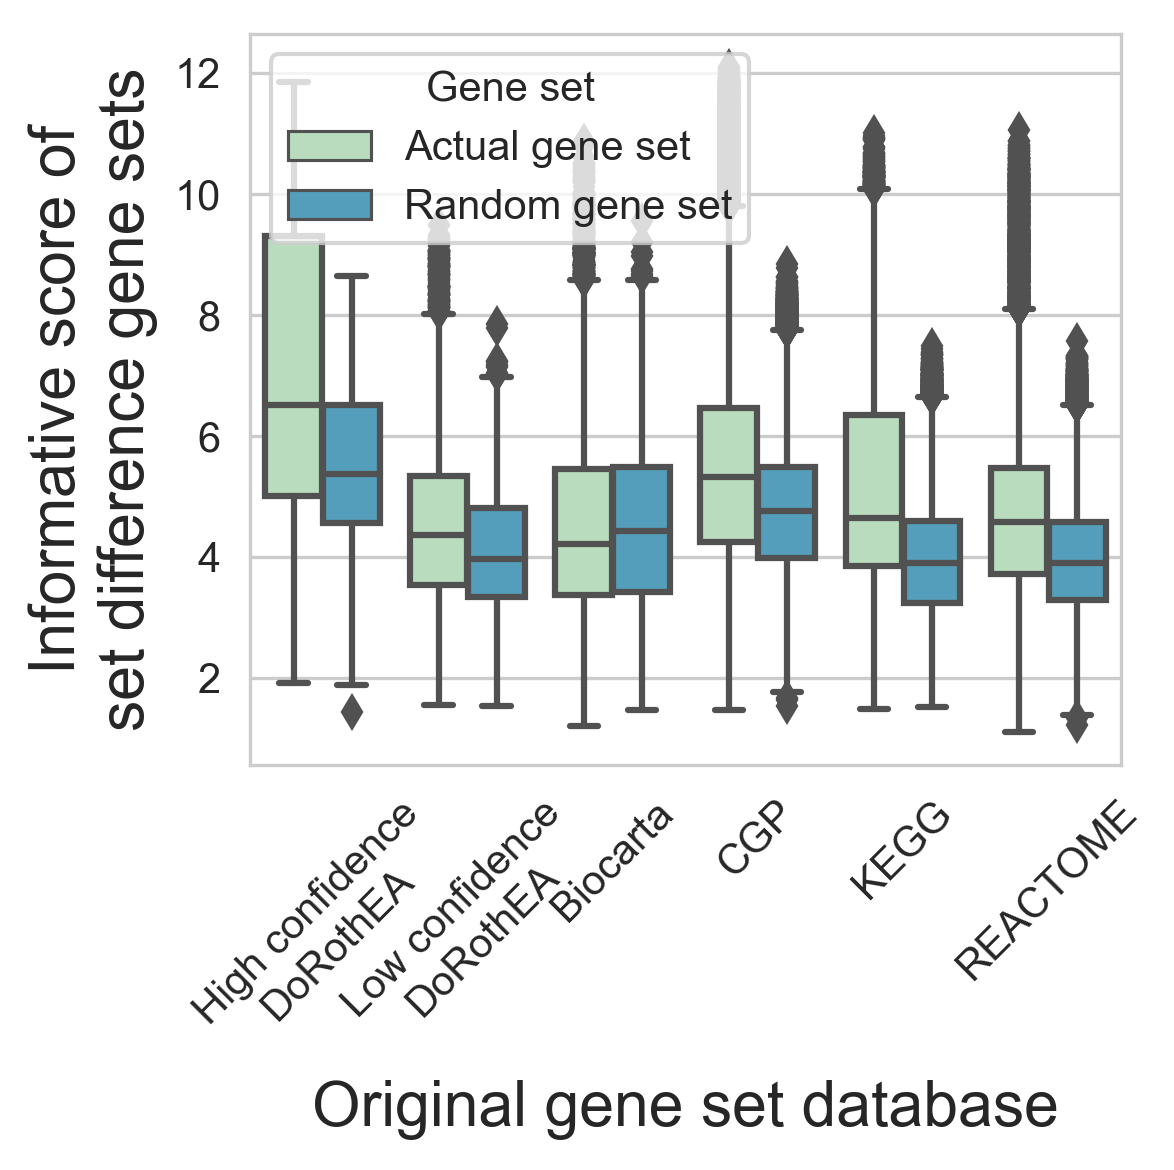

In [62]:
scores = plot_set_difference(bname='progeny', atype='_abs')
#plt.savefig('../figures/raw/Fig5B.pdf')

In [70]:
scores.index = range(len(scores.index))
scores.to_csv('../results/benchmark/progeny_abs_overlap.csv')

In [72]:
scores.head()

,Data,Delta,Size,Gene set
0,BEST_dorothea_AB,6.673754,134,Actual gene set
1,BEST_dorothea_AB,6.607057,131,Actual gene set
2,BEST_dorothea_AB,6.548815,134,Actual gene set
3,BEST_dorothea_AB,6.520633,127,Actual gene set
4,BEST_dorothea_AB,6.587330,133,Actual gene set


In [109]:
def infromative_score_decrease(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    delta={}
    sizes = {}
    for dname1 in dnames:
        delta[dname1]=[]
        sizes[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_filtered',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_filtered',dname1,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size = pd.read_csv('../results/genesets/single/csvs/%s_filtered.csv' % dname1,
                              sep=',', header=0, index_col=0)['Set'].value_counts()
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
                size=size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
                size = size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            delta[dname1]+=list(score_2minus1.values-score.values)
            sizes[dname1]+=list(size.values)
    delta_df=pd.DataFrame(columns=['Data','Delta', 'Size'])
    for dname in delta:
        temp=pd.DataFrame(columns=delta_df.columns)
        temp['Delta']=delta[dname]
        temp['Data']=dname
        temp['Size']=sizes[dname]
        delta_df=pd.concat([delta_df,temp])
    delta_df['Random']='Actual gene set'    
    delta_random={}
    sizes_random={}
    for dname1 in dnames:
        delta_random[dname1]=[]
        sizes_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_random_dist_0',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_random_dist_0',dname1,'_random_dist_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            size = pd.read_csv('../results/genesets/single/csvs/%s_random_dist_0.csv' % dname1,
                              sep=',', header=0, index_col=0)['Set'].value_counts()
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
                size=size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
                size = size[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            delta_random[dname1]+=list(score_2minus1.values-score.values)
            sizes_random[dname1]+=list(size.values)
    delta_random_df=pd.DataFrame(columns=['Data','Delta', 'Size'])
    for dname in delta_random:
        temp=pd.DataFrame(columns=delta_random_df.columns)
        temp['Delta']=delta_random[dname]
        temp['Data']=dname
        temp['Size']=sizes_random[dname]
        delta_random_df=pd.concat([delta_random_df,temp])
    delta_random_df['Random']='Random gene set'
    delta = pd.concat([delta_df,delta_random_df])
    delta.columns = ['Data', 'Delta', 'Size','Gene set']
    delta = delta.sort_values(['Data', 'Gene set'])
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.barplot(delta['Data'],delta['Delta'], hue=delta['Gene set'])
    plt.xlabel('Removed gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                            'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score decrease', size=15)
    plt.tight_layout()
    plt.legend(loc=0, title='Gene set')
    return delta

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


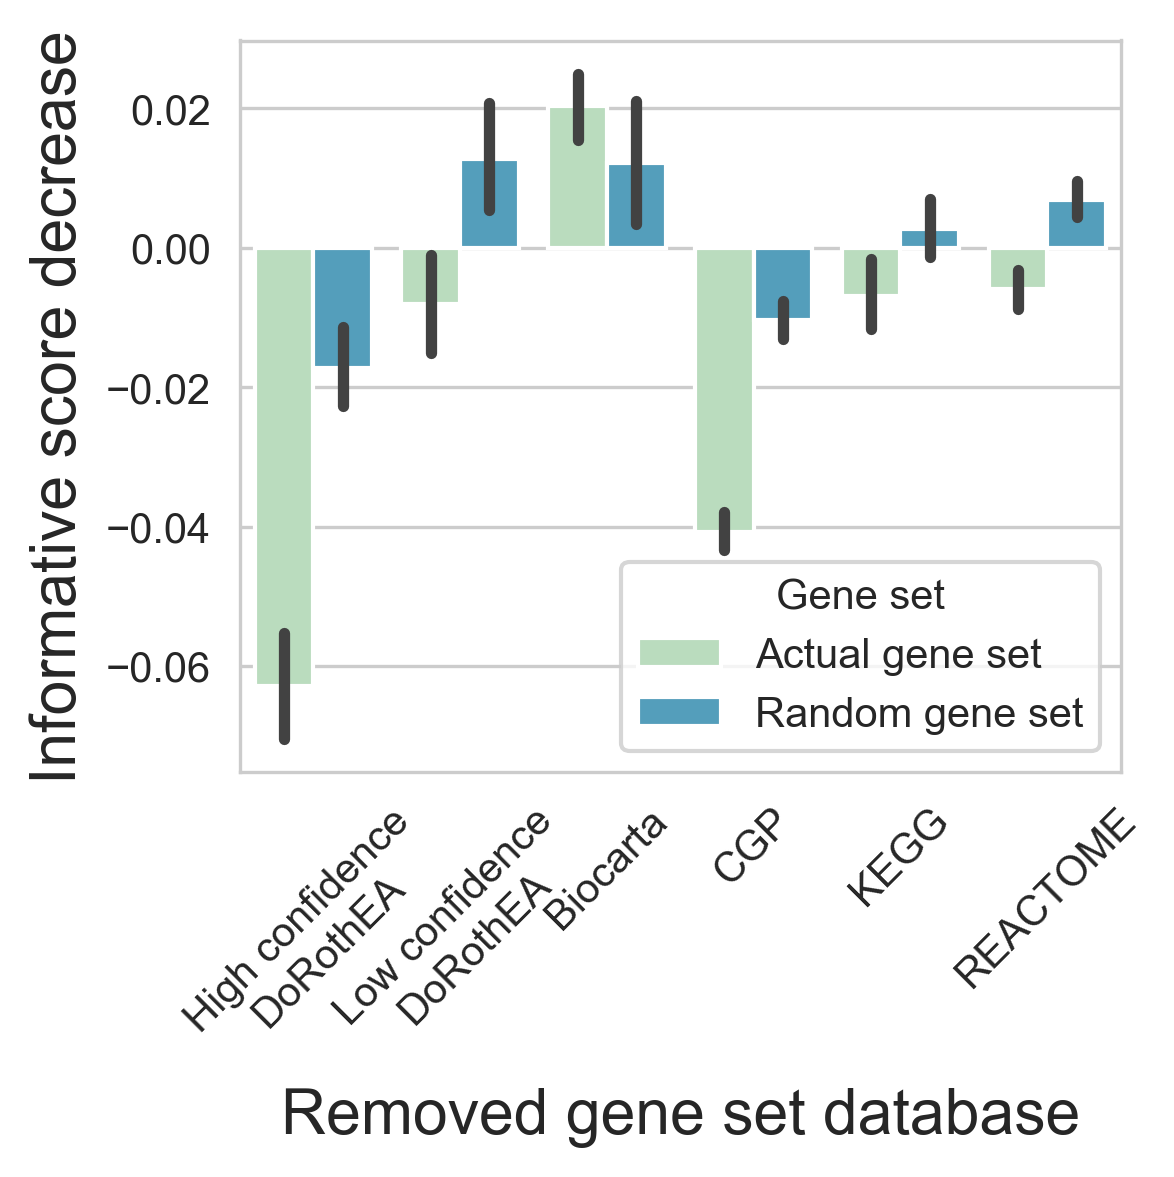

In [114]:
delta = infromative_score_decrease(bname='gdsc', atype='_abs')
#plt.savefig('../figures/raw/Fig5C.pdf')

In [118]:
temp = delta[delta['Gene set']=='Actual gene set']

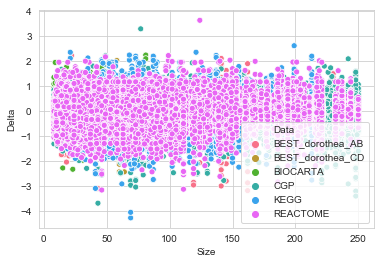

In [121]:
sns.scatterplot(temp['Size'], temp['Delta'], hue=temp['Data'])

In [26]:
fil = delta['Gene set'] == 'Actual gene set'

In [27]:
print(pairwise_tukeyhsd(delta['Delta'][fil], delta['Data'][fil]))

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
BEST_dorothea_AB BEST_dorothea_CD   0.0548 0.001  0.0384  0.0711   True
BEST_dorothea_AB         BIOCARTA   0.0832 0.001  0.0704   0.096   True
BEST_dorothea_AB              CGP   0.0221 0.001  0.0115  0.0327   True
BEST_dorothea_AB             KEGG    0.056 0.001  0.0445  0.0675   True
BEST_dorothea_AB         REACTOME    0.057 0.001  0.0464  0.0675   True
BEST_dorothea_CD         BIOCARTA   0.0284 0.001  0.0127  0.0441   True
BEST_dorothea_CD              CGP  -0.0327 0.001 -0.0466 -0.0188   True
BEST_dorothea_CD             KEGG   0.0012   0.9 -0.0134  0.0158  False
BEST_dorothea_CD         REACTOME   0.0022   0.9 -0.0117  0.0161  False
        BIOCARTA              CGP  -0.0611 0.001 -0.0705 -0.0516   True
        BIOCARTA             KEGG  -0.0272 0.001 -0.0376 -0.0167

In [76]:
model = smf.ols('Delta ~ Data', data=delta[delta['Random']==False]).fit()

In [78]:
model.params

Intercept                  -0.273290
Data[T.BEST_dorothea_CD]    0.225076
Data[T.BIOCARTA]            0.173529
Data[T.CGP]                 0.120168
Data[T.KEGG]                0.167289
Data[T.REACTOME]            0.176242
dtype: float64

In [79]:
 -0.273290 + 0.120168

-0.15312199999999998

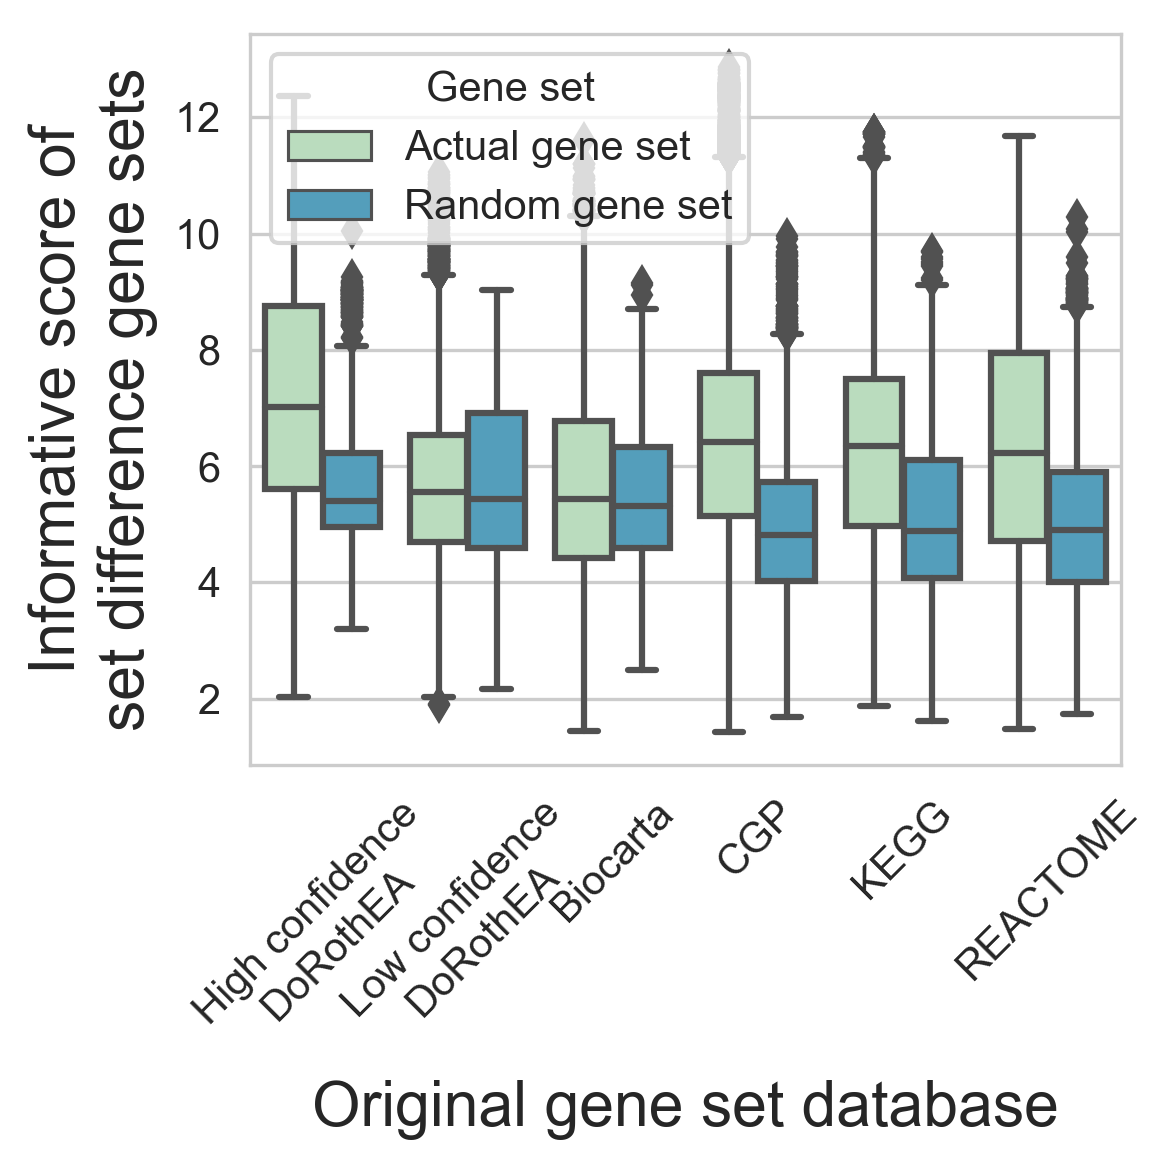

In [12]:
temp = plot_set_difference(bname='progeny', atype='')
plt.savefig('../figures/raw/SFig6A.pdf')

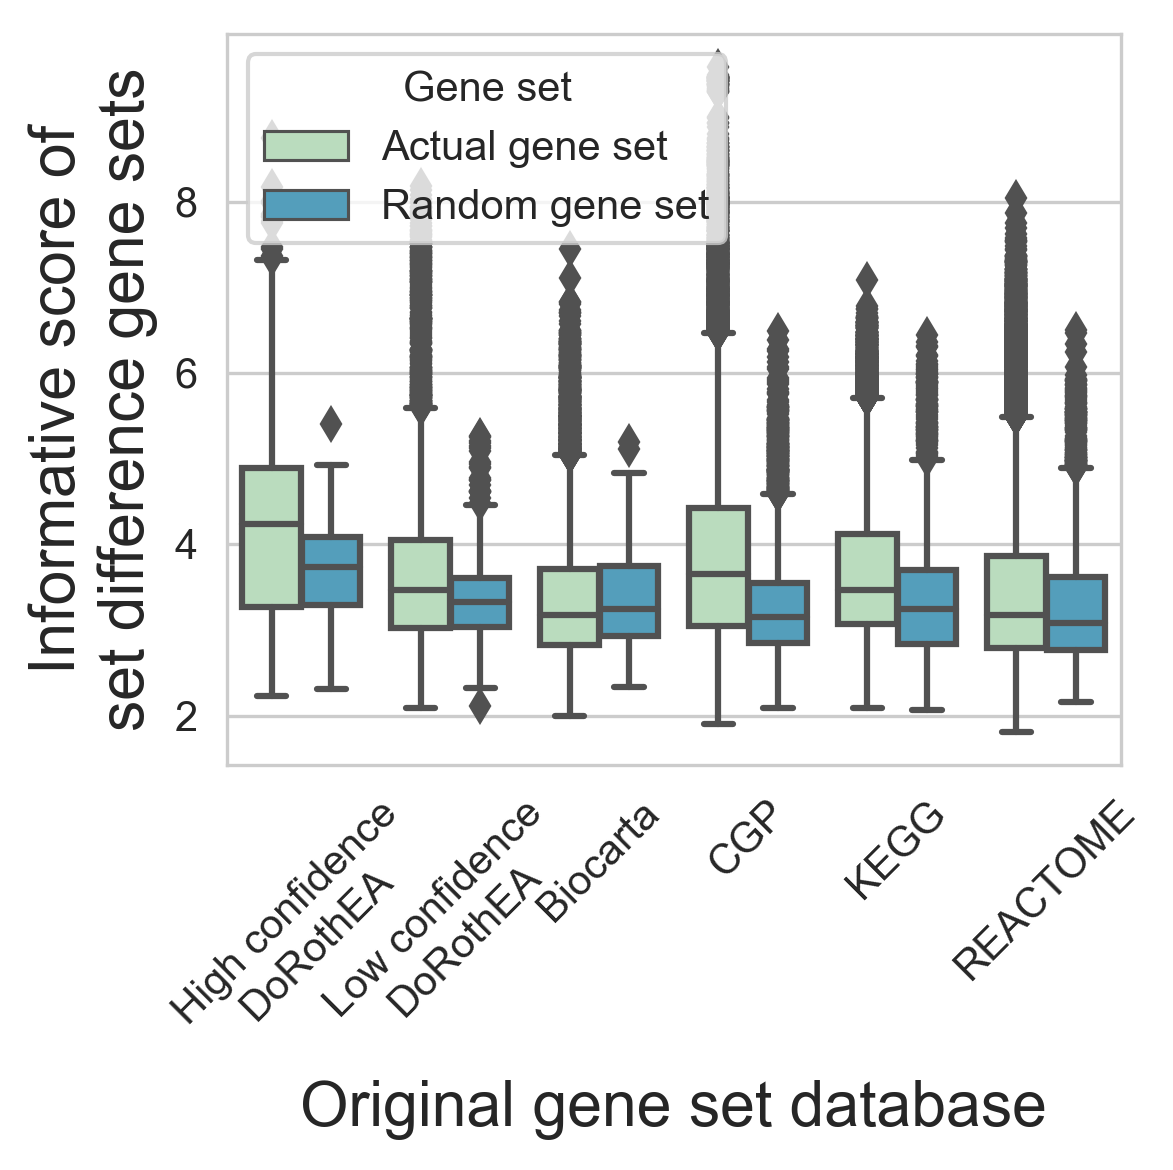

In [13]:
temp = plot_set_difference(bname='gdsc', atype='_abs')
plt.savefig('../figures/raw/SFig6B.pdf')

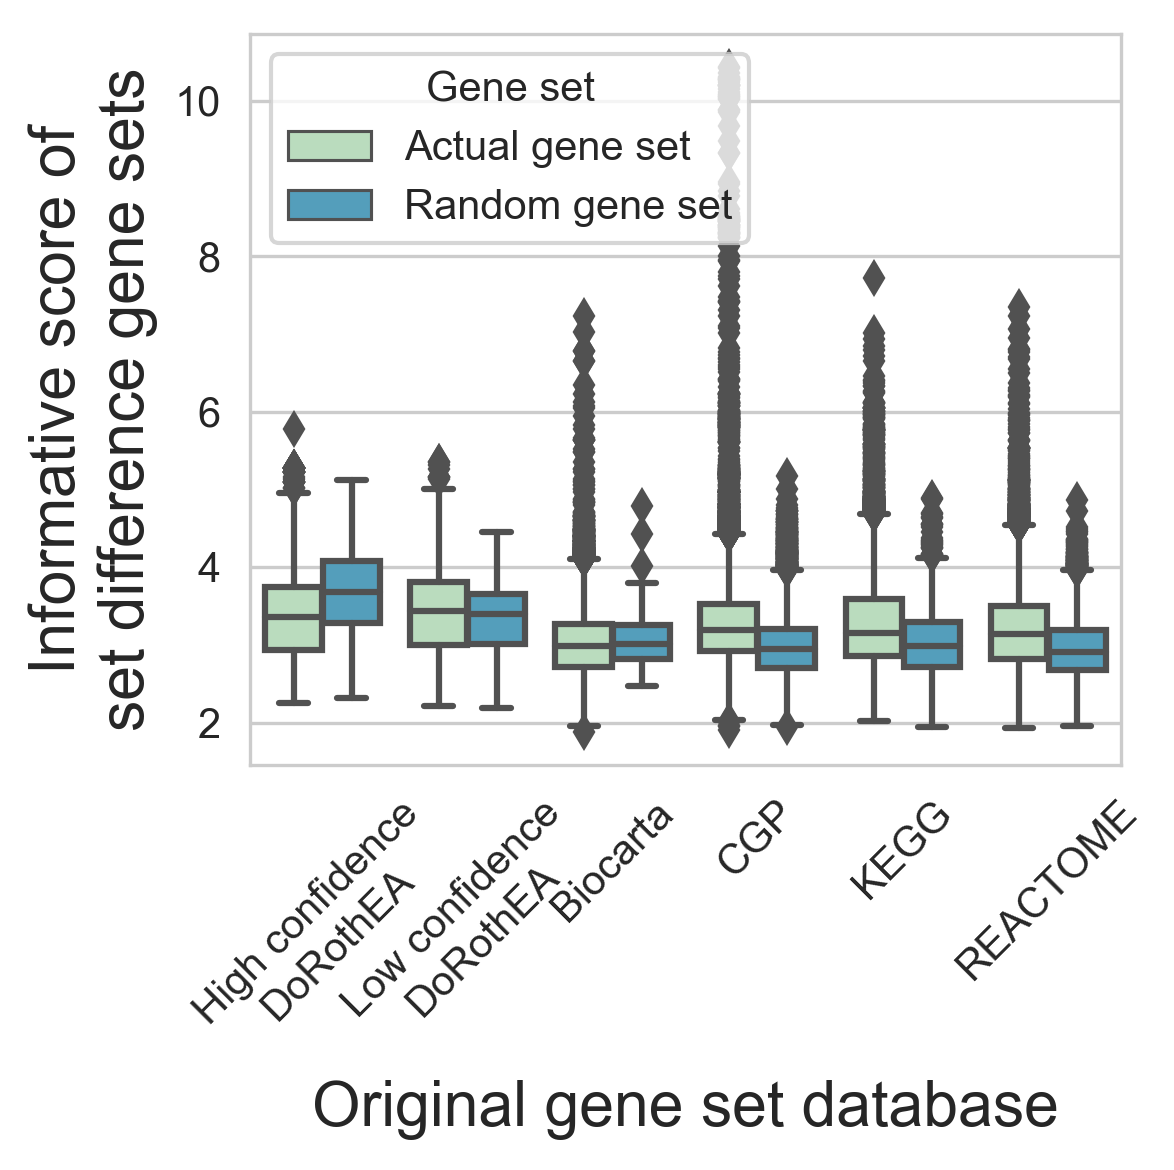

In [14]:
temp = plot_set_difference(bname='gdsc', atype='')
plt.savefig('../figures/raw/SFig6C.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


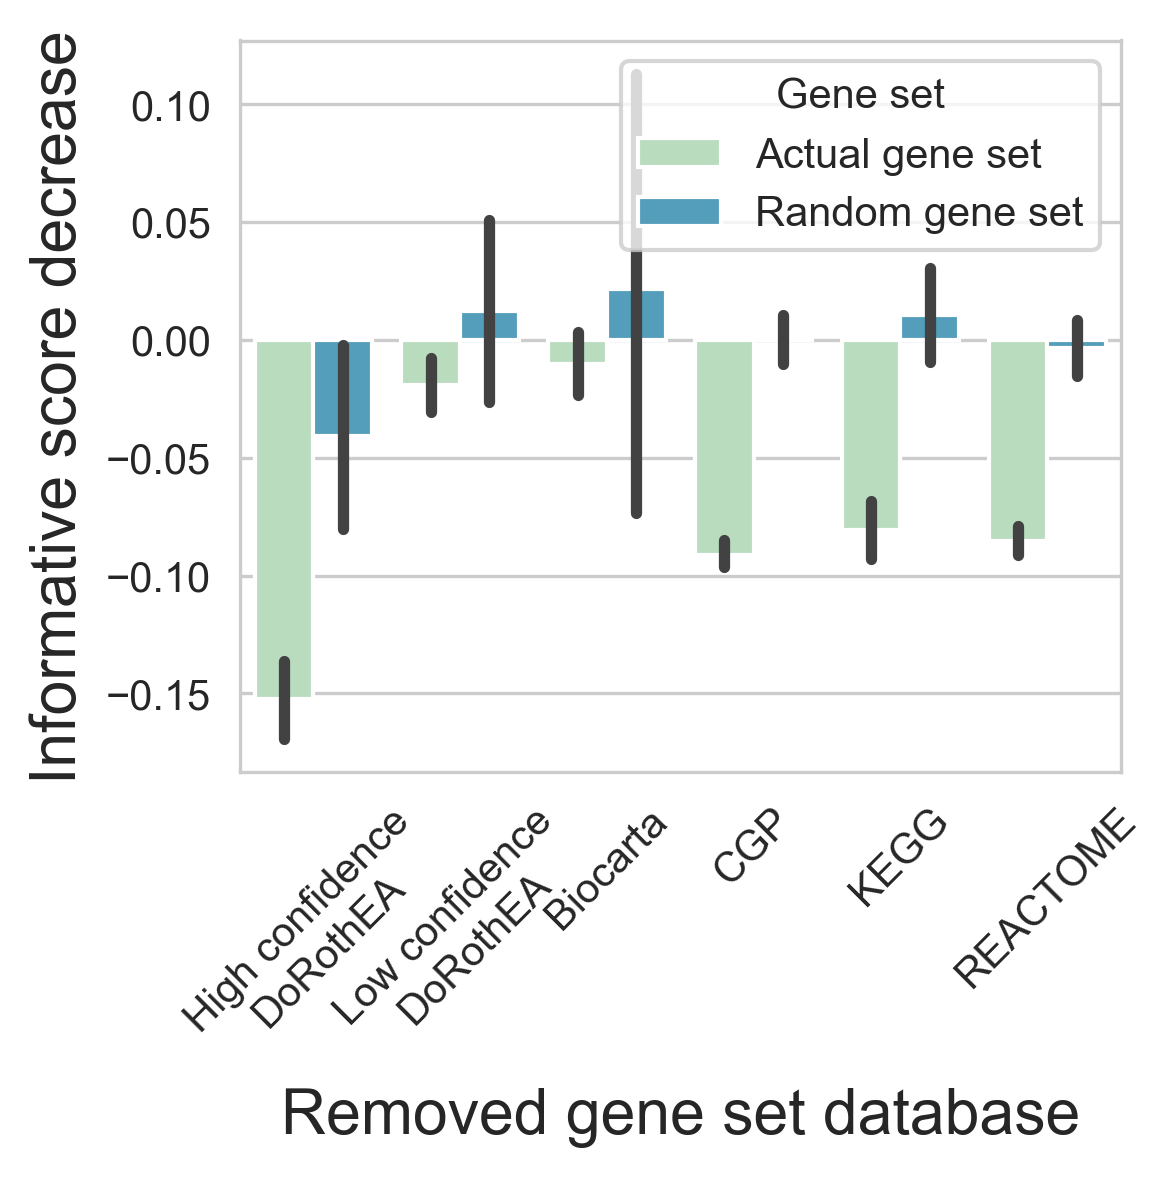

In [15]:
temp = infromative_score_decrease(bname='progeny', atype='')
plt.savefig('../figures/raw/SFig6D.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


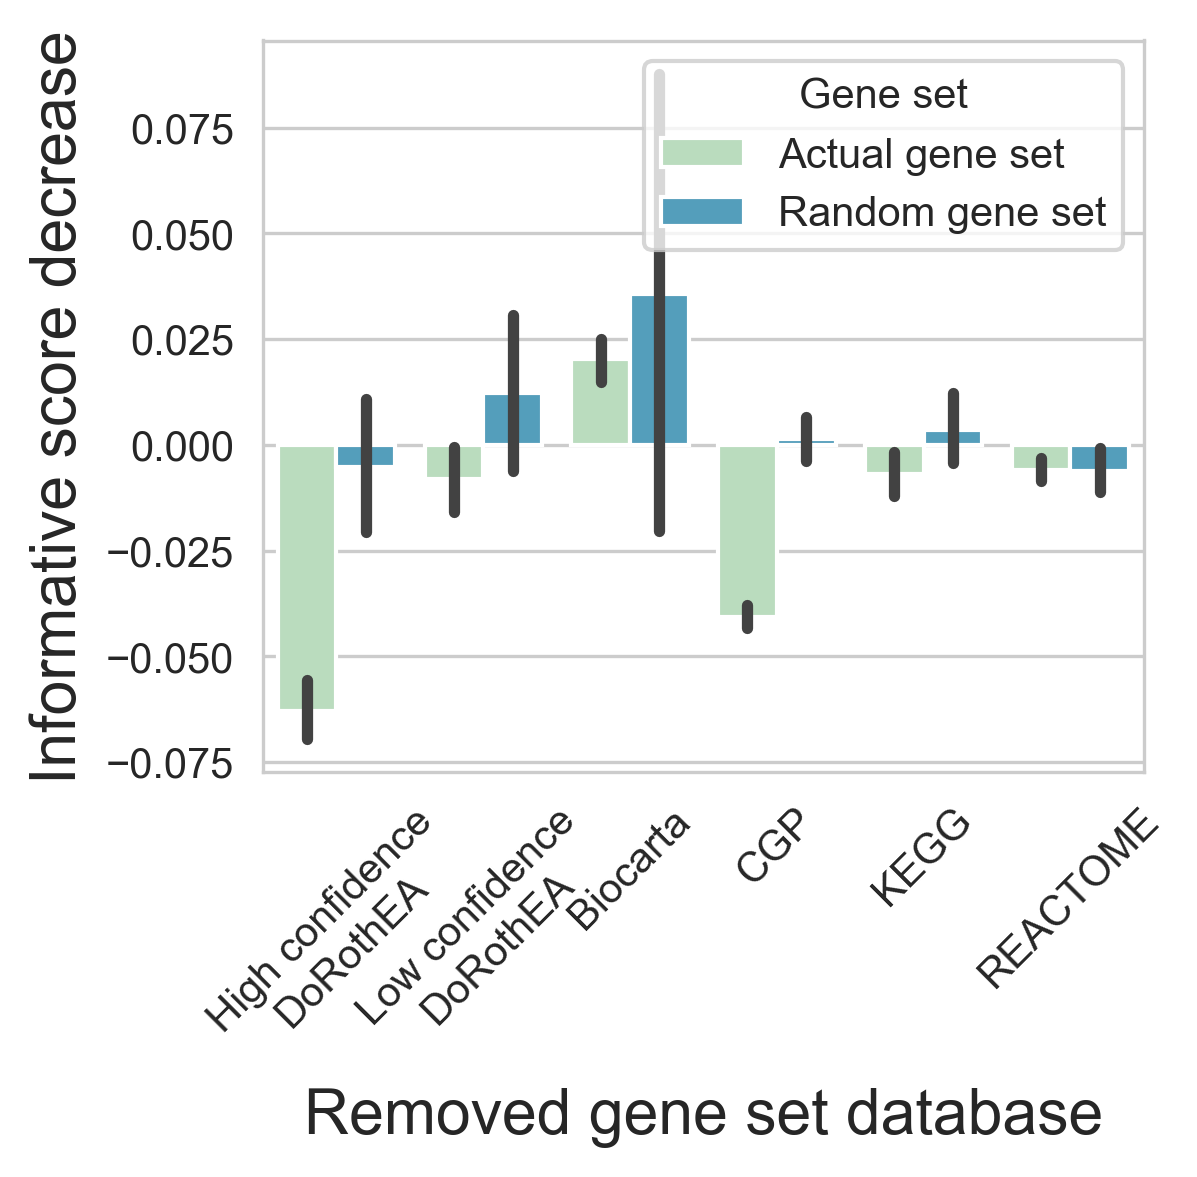

In [16]:
temp = infromative_score_decrease(bname='gdsc', atype='_abs')
plt.savefig('../figures/raw/SFig6E.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


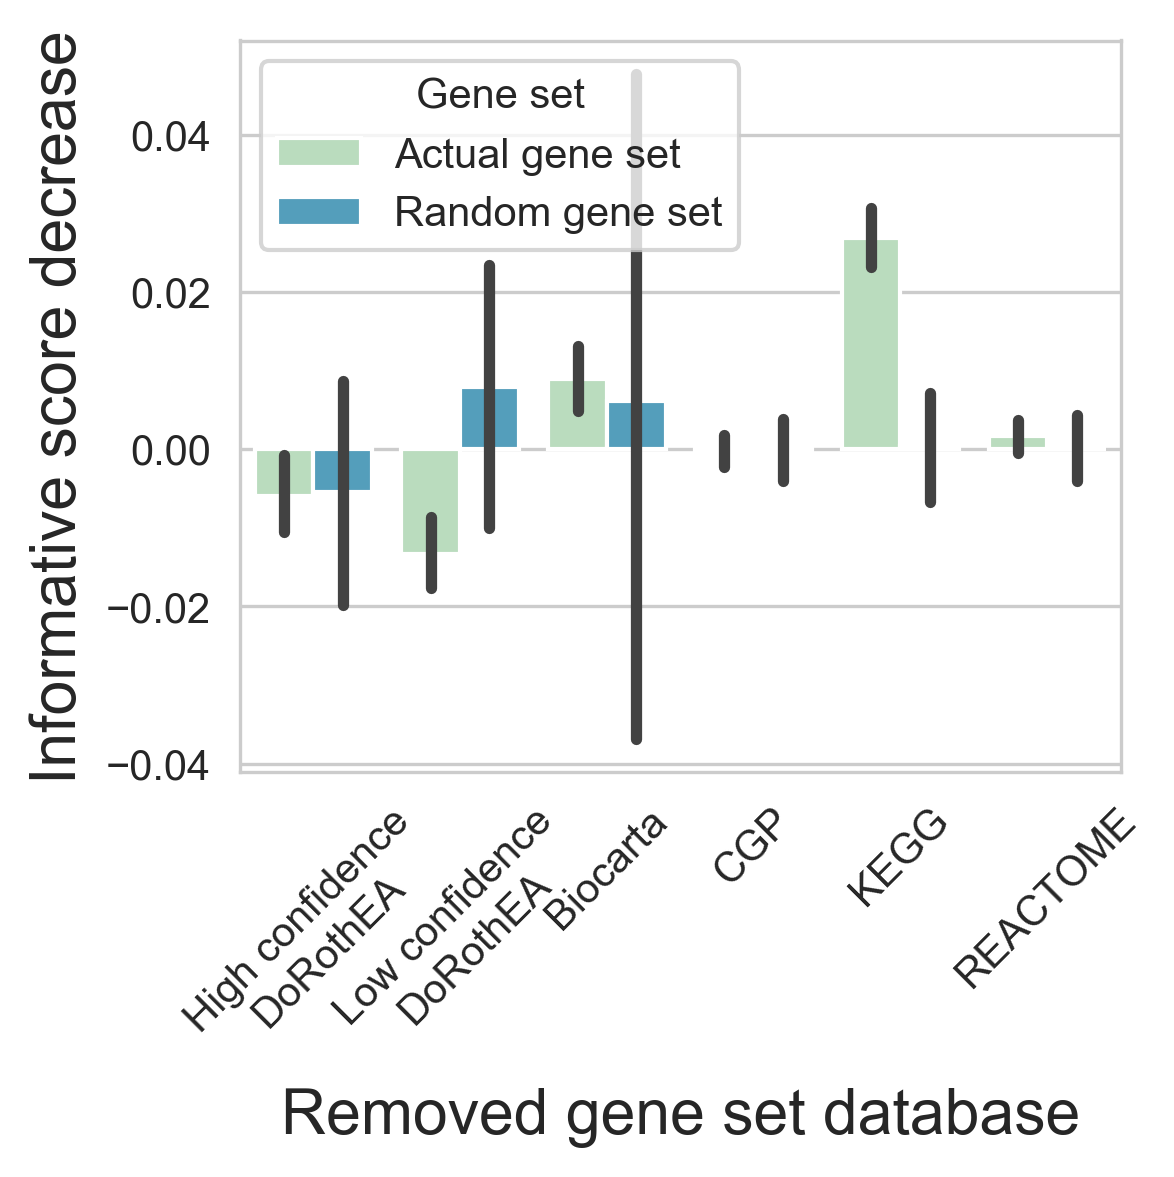

In [17]:
temp = infromative_score_decrease(bname='gdsc', atype='')
plt.savefig('../figures/raw/SFig6F.pdf')